# **TF-IDF + Logistic Regression Model**

### **Import Libraries**

In [20]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (classification_report, confusion_matrix, 
                             ConfusionMatrixDisplay, accuracy_score, 
                             precision_recall_fscore_support)
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
import nltk

### **Download NLTK resources**

In [21]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
stemmer = SnowballStemmer('english')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### **1. Data Load**

In [22]:
df = pd.read_csv('/kaggle/input/hate-speech-and-offensive-language-dataset/labeled_data.csv')
df = df[['tweet', 'class']].dropna()
label_map = {0: 'Hate', 1: 'Offensive', 2: 'Neutral'}
df['label'] = df['class'].map(label_map)

### **2. Text Preprocessing Function**

In [23]:
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'http\S+|www.\S+', '', text)        # Remove URLs
    text = re.sub(r'@\w+', '', text)                  # Remove mentions
    text = re.sub(r'[^a-z\s]', '', text)              # Remove punctuation and numbers
    tokens = text.split()
    tokens = [stemmer.stem(word) for word in tokens if word not in stop_words]
    return ' '.join(tokens)

df['clean_tweet'] = df['tweet'].apply(clean_text)

### **3. Train/Test Split**

In [24]:
X_train, X_test, y_train, y_test = train_test_split(
    df['clean_tweet'], df['label'], test_size=0.2, random_state=42, stratify=df['label']
)

### **4. TF-IDF Feature Extraction**

In [25]:
tfidf = TfidfVectorizer(ngram_range=(1,2), max_features=5000)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

# **5. Model Training: Logistic Regression**

In [26]:
clf = LogisticRegression(max_iter=500, class_weight='balanced', random_state=42)
clf.fit(X_train_tfidf, y_train)

LogisticRegression(class_weight='balanced', max_iter=500, random_state=42)

### **Training and Validation Accuracy**

In [27]:
train_pred = clf.predict(X_train_tfidf)
train_acc = accuracy_score(y_train, train_pred)
val_acc = accuracy_score(y_test, clf.predict(X_test_tfidf))
print(f"\nTraining Accuracy:   {train_acc:.4f}")
print(f"Validation Accuracy: {val_acc:.4f}")


Training Accuracy:   0.8911
Validation Accuracy: 0.8598


### Precision, Recall, F1, Support for Each Class

In [29]:
prec, recall, f1, support = precision_recall_fscore_support(
    y_test, clf.predict(X_test_tfidf), labels=clf.classes_
)
prf_df = pd.DataFrame({
    "Class": clf.classes_,
    "Precision": prec,
    "Recall": recall,
    "F1-score": f1,
    "Support": support
})
print(prf_df)

       Class  Precision    Recall  F1-score  Support
0       Hate   0.330896  0.632867  0.434574      286
1    Neutral   0.774951  0.950780  0.853908      833
2  Offensive   0.970779  0.856957  0.910324     3838


### **Confusion Matrix**

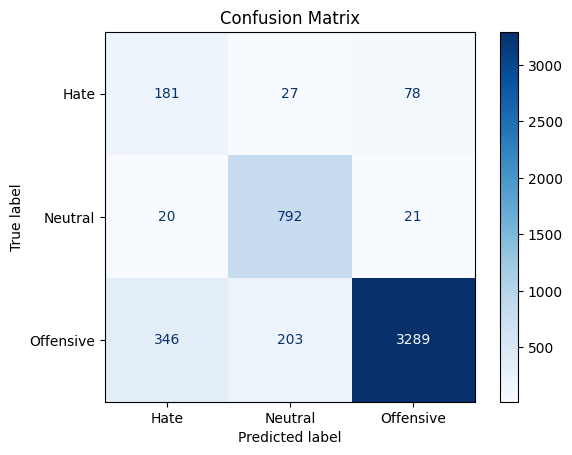

In [30]:
cm = confusion_matrix(y_test, clf.predict(X_test_tfidf), labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix')
plt.show()

### **Word Heatmaps (Bar Plots) of Top Features Per Class**

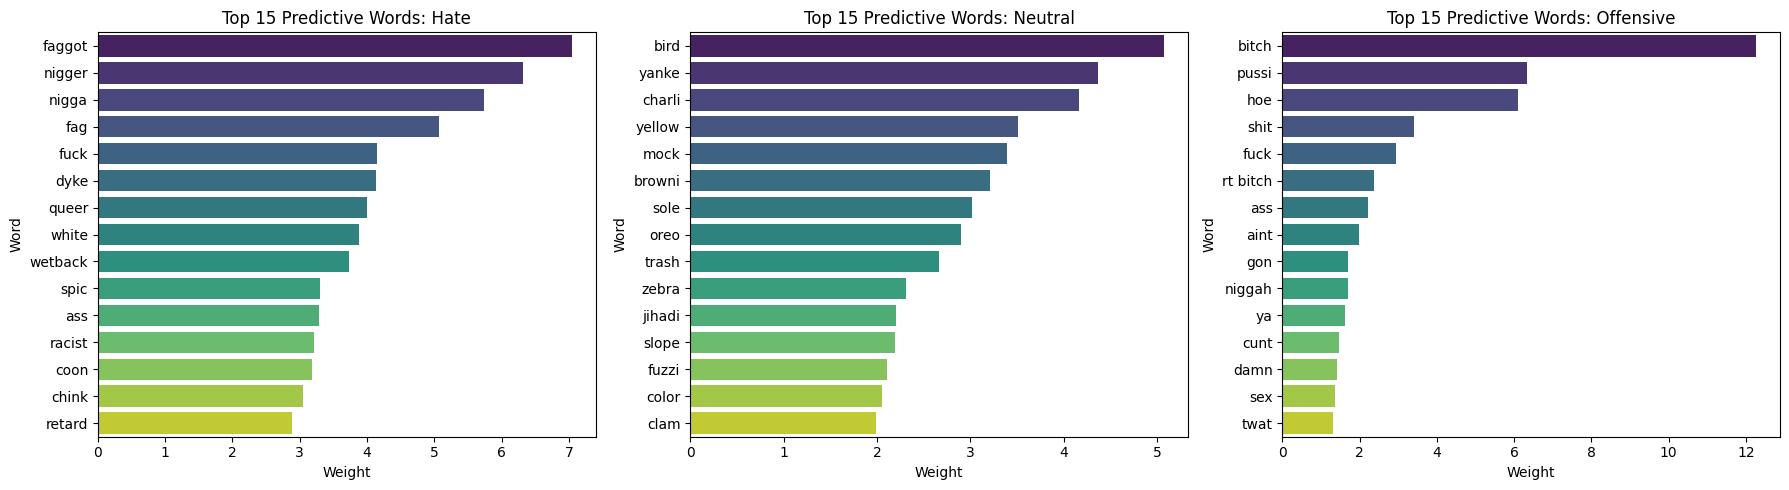

In [31]:
def plot_top_words(classifier, vectorizer, class_labels, top_n=15):
    feature_names = np.array(vectorizer.get_feature_names_out())
    fig, axs = plt.subplots(1, len(class_labels), figsize=(18, 5), sharey=False)
    for idx, class_label in enumerate(class_labels):
        if hasattr(classifier, "coef_"):
            class_coefs = classifier.coef_[idx]
            top_pos_idx = np.argsort(class_coefs)[-top_n:][::-1]   # top positive
            top_neg_idx = np.argsort(class_coefs)[:top_n]          # top negative
            top_words = feature_names[top_pos_idx]
            top_weights = class_coefs[top_pos_idx]
            # Bar plot (Heatmap style)
            sns.barplot(x=top_weights, y=top_words, ax=axs[idx], palette="viridis")
            axs[idx].set_title(f"Top {top_n} Predictive Words: {class_label}")
            axs[idx].set_xlabel("Weight")
            axs[idx].set_ylabel("Word")
    plt.tight_layout()
    plt.show()

plot_top_words(clf, tfidf, clf.classes_, top_n=15)

### Predict on New Text

In [37]:
def predict_tweet(text):
    processed = clean_text(text)
    feats = tfidf.transform([processed])
    pred = clf.predict(feats)[0]
    return pred

print("Sample prediction:", predict_tweet("You are so stupid!"))

Sample prediction: Hate
